In [52]:
import pandas as pd
import numpy as np
import os
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
import seaborn as sns

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization, Conv2D, Bidirectional, LSTM, TimeDistributed
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

In [2]:
window_size = 25
tf.random.set_seed(1)
np.random.seed(1)

## Getting the data

Before you run this, make sure that you have generated a sliding_windows file by running 01_sliding_windows.

In [3]:
data_path = '../data/'

In [4]:
final_sliding_windows_thingy = pd.read_csv(data_path + '/sliding_windows_Thingy_smallest25_size25_step25.csv')
final_sliding_windows_respeck = pd.read_csv(data_path + '/sliding_windows_Respeck_smallest25_size25_step25.csv')

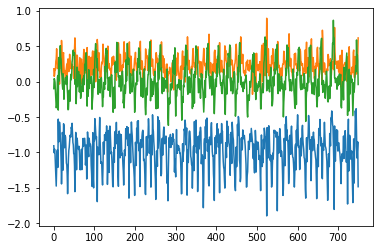

In [5]:
def plot_by_id(df, i): 
    plot_recording = df[df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
     
#plot_by_id(final_sliding_windows_respeck, 'Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43')
plot_by_id(final_sliding_windows_thingy, 'Thingy_s1541031_Climbing stairs_06-10-2021_11-27-07')

## Some definitions

### Prepping the CNN model

In [6]:
def prep_cnn():
    print("Prepping CNN...")
    
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    #filters = [3, 7, 11]

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                     input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    #model.summary()
    
    model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])
    
    print("CNN prepped.")
    
    return model

In [7]:
# Wan et al. also used sinwod size 25, good for borrowing arch

def wan_cnn(save_to=None):
    """The kernel_sizes of each convolutional layer and pooling layer are 7, 3 and 1, 
    and the convolution depth (depth_size) is 64 steps, stride_size= 3, and batch_size= 64. 
    The number of hidden units in the fully connected layer is 512. During the training, 
    we used a dropout layer with the following parameters to prevent overfitting: 0.1, 0.25 and 0.5."""
    
    kernels = [7,3,1]
    dropouts = [0.1,0.25,0.5]
    f=64
    n_features = 6
    n_classes = len(class_labels)
    s=6
    
    model = Sequential()

    model.add(Conv1D(filters=f, kernel_size=kernels[0],
                     input_shape=(window_size, n_features)))
    #They don't mention activation method
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[0]))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[1]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[1]))
    
    model.add(Conv1D(filters=f, kernel_size=kernels[2]))
    model.add(MaxPooling1D())
    model.add(Dropout(dropouts[2]))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'], strides=s)
    
    #save_to_models_comparisons('wan_et_al.txt', model.summary())
    print(model.summary())
    
    return model

In [8]:
def promising_cnn():
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    #model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()

    model.compile(
            optimizer=optimizers.Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
    
    return model

In [30]:
def promising_cnn_tinkering(filters=64, kernel_size=3):
    filters = filters
    kernel_size = kernel_size
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()

    model.compile(
            optimizer=optimizers.Adam(lr=0.001),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])
    
    return model

In [10]:
def try_lstm(lstm_units=128, nn_units=128):
    n_features = 6
    n_classes = len(class_labels)
    
    model = Sequential()
    model.add(
        Bidirectional(
          LSTM(
              units=lstm_units,
              input_shape=(window_size, n_features)
          )
        )
    )
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=nn_units, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['acc']
    )
    
    return model

In [11]:
def cnn_lstm():
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    
    # define CNN model
    cnn = Sequential()
    cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)))
    cnn.add(MaxPooling1D())
    cnn.add(Flatten())
    
    # define LSTM model
    model = Sequential()
    model.add(TimeDistributed(cnn))
    """
    model.add(
        Bidirectional(
          LSTM(
              units=128,
              input_shape=(1,704)
          )
        )
    )
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['acc']
    )
    """
    
    return cnn

In [12]:
def try_cnn_lstm():
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    
    model = Sequential([
          Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, 
                     input_shape=(window_size, n_features)),
        MaxPooling1D(),
        Conv1D(filters=filters, kernel_size=kernel_size, activation=activation),
        MaxPooling1D(),
           Bidirectional(LSTM(units=128)),
        Flatten(),
        Dropout(rate=0.5),
          Dense(units=128, activation='relu'),
        Dense(n_classes, activation='softmax')])
    
    model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['acc']
    )
    
    return model

In [55]:
# multi-headed cnn model
# https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

def multi_head_cnn(trainX, trainy, testX, testy):
    k1_size, k2_size, k3_size = 3, 5, 11 # 56 / 86
#     k1_size, k2_size, k3_size = 2, 3, 7 # 59 / 89
    filters = 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=filters, kernel_size=k1_size, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=filters, kernel_size=k2_size, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=filters, kernel_size=k3_size, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [13]:
def save_to_models_comparisons(save_to, text):
    model_dir = 'models/comparisons/'
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
        
    f = open(model_dir + save_to, "a")
    f.write(text)
    f.close()

### Format the input

Format data into windows - make (window_size,6) inputs

In [14]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [15]:
class_labels = {
    'Sitting': 0,
    'Sitting bent forward': 1,
    'Sitting bent backward': 2,
    'Standing': 3,
    'Lying down left': 4,
    'Lying down right': 5,
    'Lying down on stomach': 6,
    'Lying down on back': 7,
    'Walking at normal speed': 8,
    'Running': 9,
    'Climbing stairs': 10,
    'Descending stairs': 11,
    'Desk work': 12,
    'Movement': 13,
    'Falling on knees': 14,
    'Falling on the back': 15,
    'Falling on the left': 16,
    'Falling on the right': 17
}

In [16]:
def format_data(X_train_full, y_train_full, X_test_full, y_test_full):
    
    print("Formatting data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     X_test_full = X_test_full[y_test_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_test_full = y_test_full[y_test_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_test = y_test_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)
    
    X_train = []
    X_test = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (window_size, len(columns_of_interest)):
            X_train.append(group[columns_of_interest].values)

    for window_id, group in X_test_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")

        X_test.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    X_test = np.asarray(X_test)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(X_test))

    print(np.shape(y_train))
    print(np.shape(y_test))
    
    print("Data formatted.")
    return X_train, y_train, X_test, y_test

In [17]:
def format_all_data(X_train_full, y_train_full):
    # to be used when we only want a training set not test set
    
    print("Formatting data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    
    X_train = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (window_size,len(columns_of_interest)):
            X_train.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(y_train))
    
    print("Data formatted.")
    return X_train, y_train

### Accuracy of the model (+ on subset)

In [25]:
# This is used for grouping the predictions into subsets
activity_groups = {    
    'Sitting/Standing': [0,1,2,3,12], # including desk work
    'Lying': [4,5,6,7],
    'Walking': [8,10,11,13], # I include up and down stairs in this one + movement
    'Running': [9],
    'Falling': [14,15,16,17]
}
    
def group_y(y):
    grouped_y = []
    for yy in y:
        group = [i for i,v in enumerate(activity_groups.values()) if yy in v][0]
        grouped_y.append(group)
    return grouped_y

In [19]:
def evaluate(y_true_labels, y_pred_labels, save_to=None):
    print('\n')
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(y_true_labels, y_pred_labels))
    
    # compute accuracy of the subset of activities 
    grouped_y_true_labels = group_y(y_true_labels)
    grouped_y_pred_labels = group_y(y_pred_labels)

    print('\n')
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(grouped_y_true_labels, grouped_y_pred_labels))

In [20]:
def confusion_mat(y_true_labels, y_pred_labels):
    confusion_matrix = tf.math.confusion_matrix(
        y_true_labels, y_pred_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,
        name=None
    )
    
    sns.heatmap(confusion_matrix, annot=True, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())

## Without Cross-validation for development

In [21]:
def prep_dev_data(final_sliding_windows):

    # split data into training and test sets (split by subject)

    subjects = final_sliding_windows['subject_id'].unique()

    train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, train_size=0.8)

    X_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + columns_of_interest]
    y_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + ['activity_type']]
    
    X_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + columns_of_interest]
    y_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + ['activity_type']]
    
    # format the data
    X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
    
    return X_train, y_train, X_test, y_test

In [22]:
def train_dev_model(model, X_train, y_train, batch_size=100, epochs=10):

    # train the model 
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    
    return model

In [47]:
# Prep data
X_train, y_train, X_test, y_test = prep_dev_data(final_sliding_windows_thingy)

Formatting data...
(19228, 25, 6)
(4822, 25, 6)
(19228, 18)
(4822, 18)
Data formatted.


In [54]:
# # Prep data
# X_train, y_train, X_test, y_test = prep_dev_data(final_sliding_windows_thingy)

# prepare the model
# model = promising_cnn_tinkering(kernel_size=kernel_size)
model = multi_head_cnn(X_train, y_train, X_test, y_test)

# Train 
model = train_dev_model(model, X_train, y_train, batch_size=64, epochs=5)
#train multi head cnn - 3 inputs
# model = train_dev_model(model, [X_train, X_train, X_train], y_train, batch_size=64, epochs=10)    

# Test the model
y_pred_ohe = model.predict(X_test)
# test multi head cnn - 3 inputs
# y_pred_ohe = model.predict([X_test, X_test, X_test])
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

evaluate(y_true_labels, y_pred_labels)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 25, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_99 (Conv1D)              (None, 24, 64)       832         input_28[0][0]                   
____________________________________________________________________________________________

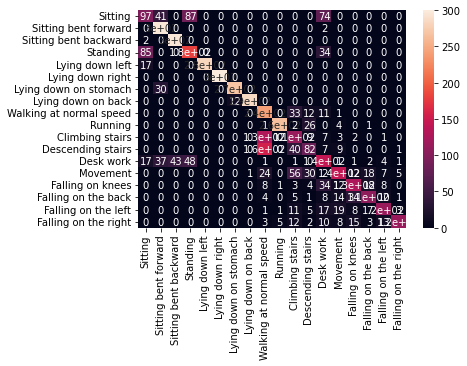

In [217]:
confusion_mat(y_true_labels, y_pred_labels)

## Train baseline model on ALL data

In [161]:
# Note: On Thingy
X = final_sliding_windows_thingy[['window_id'] + columns_of_interest]
y = final_sliding_windows_thingy[['window_id'] + ['activity_type']]

# format the data
X_train, y_train = format_all_data(X, y)
   
# prepare the CNN
model = prep_cnn()

# train the model 
train_dev_model(X_train, y_train)

Formating data...
(30267, 20, 6)
(30267, 18)
Data formatted.
Prepping CNN...
CNN prepped.


## Leave-One-Subject-Out Cross Validation

In [77]:
def get_loocv(final_sliding_windows, n=6):

    loocv = LeaveOneGroupOut()

    # # UNCOMMENT TO LEAVE ONE SUBJECT OUT####
    # # group by subject id so that one subject is left out each time
    # groups = final_sliding_windows['subject_id']
    # ########################################

    # UNCOMMENT TO LEAVE (48 / N) SUBJECTS OUT####
    # n must be a factor of 48 (there are 48 subjects in the dataset)
    #n = 6
    subj_group_mapping = {}
    for i, subj_id in enumerate(final_sliding_windows['subject_id'].unique()):
        subj_group_mapping[subj_id] = i % n
    groups = [ subj_group_mapping[subj_id] for subj_id in final_sliding_windows['subject_id'] ]
    ########################################

    X = final_sliding_windows[['window_id'] + columns_of_interest]
    y = final_sliding_windows[['window_id'] + ['activity_type']]

    # how many different subjects
    loocv.get_n_splits(X, y, groups)
    
    return loocv, X, y, groups

In [299]:
loocv, X, y, groups = get_loocv(final_sliding_windows_respeck, n=4)

y_pred_labels = np.empty(shape=(0,))
y_true_labels = np.empty(shape=(0,))

# this gives a train/test split that leaves one subject out in each iteration
for i, (train_index, test_index) in enumerate(loocv.split(X, y, groups)):
    print("Starting iteration " + str(i))
    
    X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
    y_train_full, y_test_full = y.iloc[train_index], y.iloc[test_index]
    
    X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
    
    model = promising_cnn()
    
    print("Training...")
    # todo change no. epochs
    model.fit(X_train, y_train, batch_size=32, epochs=10)
    
    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.concatenate([y_pred_labels, np.argmax(y_pred_ohe, axis=1)])
    y_true_labels = np.concatenate([y_true_labels, np.argmax(y_test, axis=1)])
    
    print(y_pred_labels.shape)
    print(y_true_labels.shape)
    
evaluate(y_true_labels, y_pred_labels)


Starting iteration 0
Formatting data...
(17318, 25, 6)
(5783, 25, 6)
(17318, 18)
(5783, 18)
Data formatted.
Model: "sequential_178"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_300 (Conv1D)          (None, 23, 64)            1216      
_________________________________________________________________
max_pooling1d_182 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
batch_normalization_126 (Bat (None, 11, 64)            256       
_________________________________________________________________
activation_126 (Activation)  (None, 11, 64)            0         
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_183 (MaxPoolin (None, 4, 64)             0         
__________

17426/17426 [==============================] - 6s 364us/sample - loss: 2.4892 - accuracy: 0.1862
Epoch 2/10
17426/17426 [==============================] - 6s 324us/sample - loss: 2.1132 - accuracy: 0.2439
Epoch 3/10
17426/17426 [==============================] - 6s 336us/sample - loss: 1.9458 - accuracy: 0.2846
Epoch 4/10
17426/17426 [==============================] - 6s 355us/sample - loss: 1.6653 - accuracy: 0.3569
Epoch 5/10
17426/17426 [==============================] - 5s 308us/sample - loss: 1.5639 - accuracy: 0.3840
Epoch 6/10
17426/17426 [==============================] - 5s 294us/sample - loss: 1.5170 - accuracy: 0.4121
Epoch 7/10
17426/17426 [==============================] - 6s 366us/sample - loss: 1.4175 - accuracy: 0.4735 - loss: 1.4172 - accuracy
Epoch 8/10
17426/17426 [==============================] - 6s 332us/sample - loss: 1.3274 - accuracy: 0.5166
Epoch 9/10
17426/17426 [==============================] - 7s 402us/sample - loss: 1.2199 - accuracy: 0.5691
Epoch 10/10
1

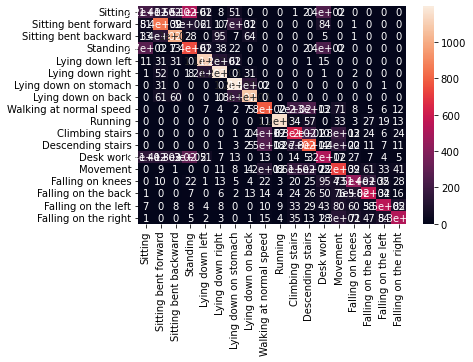

In [201]:
confusion_mat(y_true_labels, y_pred_labels)

### Save a test instance

In [41]:
for i in range(5):
    print(y_test[i])
    #np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [42]:
for i in np.arange(15,20):
    print(y_test[i])
    np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Save to file and convert to tflite

In [123]:
# Saving the model to file
model_name = 'cnn_simple_full_thingy'

export_dir = 'models\\' + model_name
tf.saved_model.save(model,export_dir)

# Convert the saved tensorflow model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the tensorflow lite model to file
import pathlib
tflite_model_file = pathlib.Path('models/' + model_name + '.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: models\cnn_simple_full_thingy\assets


473324